In [1]:
from importing import *
from TravelAndMutate.randominterface import NumpyRandomGenerator
from TravelAndMutate.system import SystemMix as System

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from time import time
from scipy.optimize import root_scalar

In [3]:
seed = np.prod([ord(c) for c in "TravelAndMutate"]).astype("uint32")
rng = NumpyRandomGenerator(seed)

In [4]:
def kernel(rng, tmax, params, commuting_mat):
    sys = System(rng.cpprng, 1, commuting_mat, params.to_records(index=False))
    sys.spreadForTime(tmax)
    return [pd.DataFrame.from_records(sys.getFullTrajectory(p), index="t") / params["N"][p] for p in range(params.shape[0])]

In [5]:
def Rinf_equation(Rinf, R0, s0):
    return 1 - Rinf - s0 * np.exp(-Rinf*R0)

,0,1,2
0,1.000000,0.075914,0.059231
1,0.031111,1.000000,0.009947
2,0.000219,0.063203,1.000000


,N,beta,epsilon,mu,I0,R0
Patch,,,,,,
0,1000000,0.061043,0.095366,0.039351,2,1.792283
1,1000000,0.046905,0.098848,0.033507,2,1.470772
2,1000000,0.058341,0.099740,0.025645,2,2.363728


Duration per replica: 0.06 sec


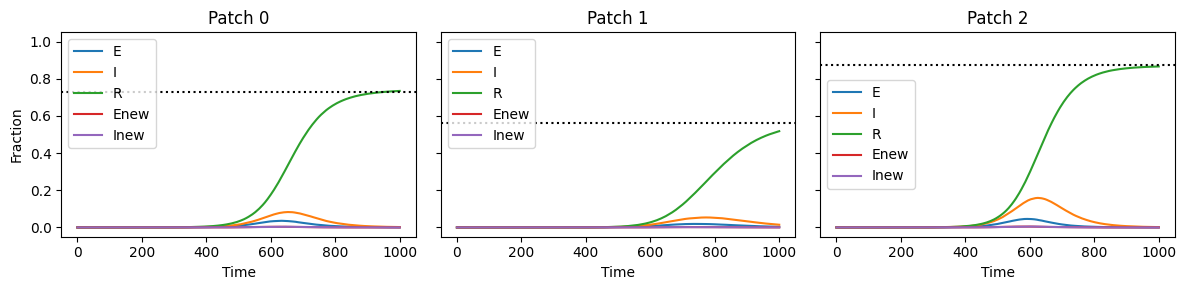

In [6]:
start = time()

Npatch = 3

commuting = np.where(np.eye(Npatch).astype(bool), 1, rng.rng.random(size=(Npatch,Npatch))/Npatch**2)
display(pd.DataFrame(commuting))

tmax = 1000

params = pd.DataFrame()
params["N"] = np.full(Npatch, 1e6, dtype="u4")
params["beta"] = np.full(Npatch, 0.06) + rng.rng.normal(scale=0.01, size=Npatch)
params["epsilon"] = np.full(Npatch, 0.1) + rng.rng.normal(scale=0.005, size=Npatch)
params["mu"] = np.full(Npatch, 0.03) + rng.rng.normal(scale=0.005, size=Npatch)
params["I0"] = np.full(Npatch, 2, dtype="u4")
params.index.name = "Patch"
display(params)

reps = 5
for i in range(reps):
    result = kernel(rng, tmax, params, commuting)

end = time()
print(f"Duration per replica: {np.round((end-start)/5, 2)} sec")

params["R0"] = commuting @ (params["beta"] / params["mu"])

fig, axs = plt.subplots(1,3,figsize=(12,3),sharey=True)
for i in range(min(Npatch,len(axs))):
	result[i].drop("S", axis=1).plot(ax=axs[i])
	axs[i].set_title(f"Patch {i}")
	axs[i].set_xlabel("Time")
	axs[i].set_ylabel("Fraction")
	Rinf = root_scalar(Rinf_equation, args=(params["R0"][i],1-params["I0"][i]/params["N"][i]), x0=params["R0"][i]).root
	axs[i].axhline(Rinf, color="k", linestyle=":")
	axs[i].set_ylim([-0.05,1.05])
fig.tight_layout()

In [10]:
print(params.to_markdown())

|   Patch |     N |      beta |   epsilon |        mu |   I0 |      R0 |
|--------:|------:|----------:|----------:|----------:|-----:|--------:|
|       0 | 1e+06 | 0.0610435 | 0.0953655 | 0.0393507 |    2 | 1.79228 |
|       1 | 1e+06 | 0.0469055 | 0.0988482 | 0.0335067 |    2 | 1.47077 |
|       2 | 1e+06 | 0.0583409 | 0.0997395 | 0.0256454 |    2 | 2.36373 |


In [ ]:
°